Importing Libraries

In [1]:
from qiskit import QuantumRegister,ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np
from fractions import Fraction
from collections import Counter
simulator = Aer.get_backend('aer_simulator')

We use the adder gate:

In [16]:
n = 22
b = 2
a = 3
qft = QFT(n).decompose()
qftdagger = QFT(n,inverse=True).decompose()
adder= QuantumCircuit(n)
bb = bin(b)[::-1]
for i in range(len(bb)):
    if bb[i]=='1': qc.x(i)
adder.barrier(range(n))
adder = adder.compose(qft)
adder.barrier(range(n))

for i in range(n):
    phi = np.divide(2 * np.pi * a , 2**(i+1))
    adder.rz(phi, n-i-1)
adder.barrier(range(n))

adder = adder.compose(qftdagger)
#display(Statevector(qc).draw())
adder.measure_all()
# qc.draw()

In [18]:
%%time
sim= Aer.get_backend('aer_simulator')

counts = sim.run(adder).result().get_counts()

print(counts)
#plot_histogram(counts)

{'0000000000000000000011': 1024}
CPU times: total: 7.84 s
Wall time: 3.98 s


In [5]:
def adder(n,a) -> QuantumCircuit:
    qc= QuantumCircuit(n)
    for i in range(n):
        phi = np.divide(2 * np.pi * a , 2**(i+1))
        qc.rz(phi, n-i-1)
    qc.name = 'ADD'
    return qc

In [6]:
def subtract(n,a) -> QuantumCircuit:
    qc= QuantumCircuit(n)
    for i in range(n):
        phi = np.divide(2 * np.pi * a , 2**(i+1))
        qc.rz(-phi, n-i-1)
    qc.name = 'SUB'
    return qc

In [25]:
def modular_adder(n,a,N) -> QuantumCircuit:
    qc= QuantumCircuit(n+2)
    qc = qc.compose(adder(n+1,a),range(n+1))
    qc = qc.compose(subtract(n+1,N), range(n+1))
    qft = QFT(n+1).decompose()
    qftdagger = QFT(n+1,inverse=True).decompose()
    qc = qc.compose(qftdagger,range(n+1))
    qc.cx(n,n+1)
    qc = qc.compose(qft,range(n+1))
    qq = [-1]
    qq.extend(range(n+1))
    qc = qc.compose(adder(n+1,N).control().decompose(),qq)
    qc = qc.compose(subtract(n+1,a),range(n+1))
    qc = qc.compose(qftdagger,range(n+1))
    qc.x(n)
    qc.cx(n,n+1)
    qc.x(n)
    qc = qc.compose(qft,range(n+1))
    qc = qc.compose(adder(n+1,a),range(n+1))
    qc.name = 'MA'
    return qc

In [26]:
def multiplier(n,a,N) -> QuantumCircuit:
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    qc = QuantumCircuit(qrx,qrb,qra)
    qft = QFT(n+1).decompose()
    qftdagger = QFT(n+1,inverse=True).decompose()
    qc = qc.compose(qft,qrb)
    for i in range(n):
        qs = [i]
        qs.extend(range(n,2*n+2))
        qc = qc.compose(modular_adder(n,2**(i) * a,N).control().decompose(), qs)
    qc = qc.compose(qftdagger,qrb)

    return qc

In [9]:
def swapper(n) -> QuantumCircuit:
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')

    qc = QuantumCircuit(qrx,qrb)

    for i in range(n):
        qc.swap(i, n+i)
    
    return qc

In [32]:
def imultiplier(n,a,N) -> QuantumCircuit:
    qc = multiplier(n,a,N).inverse()
    return qc

In [33]:
def modular_exponent(n,a,N) -> QuantumCircuit:
    qrp = QuantumRegister(1, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')

    qc = QuantumCircuit(qrp,qrx,qrb,qra)
    qc = qc.compose(multiplier(n,a,N).control().decompose(), range(2*n+3))
    qc = qc.compose(swapper(n).control().decompose(), range(2*n+2))
    qc = qc.compose(imultiplier(n,1/a,N).control().decompose(), range(2*n+3))

    return qc

In [34]:
def shor(n,a,N) -> QuantumCircuit:
    qrp = QuantumRegister(2*n, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(2*n,'M')

    qftdagger = QFT(2*n,inverse=True).decompose()

    qc = QuantumCircuit(qrp,qrx,qrb,qra,mes)
    
    qc.h(qrp)
    qc.x(qrx[0])
    for i in range(2*n):
        qq = [i]
        qq.extend(range(2*n, 4*n+2))
        qc = qc.compose(modular_exponent(n,(a**(2**i))%N,N), qq)
    
    qc = qc.compose(qftdagger, qrp)
    qc.measure(qrp,mes)
    return qc

# Testing the adder

In [7]:
def aplusb(n,a,b) -> QuantumCircuit:
    qft = QFT(n).decompose()
    qftdagger = QFT(n,inverse=True).decompose()
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n)

    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)

    qc = qc.compose(qft,range(n))
    qc = qc.compose(adder(n,a),range(n))
    qc = qc.compose(qftdagger, range(n))
    qc.measure_all()
    return qc

In [9]:
a = 2 ** 5 + 1
b = 2 ** 3 + 2
print(bin(a+b))
print(simulator.run(aplusb(10,a,b), shots=10).result().get_counts())

0b101011
{'0000101011': 10}


# Testing the inverse of the adder

In [10]:
def bminusa(n,a,b) -> QuantumCircuit:
    qft = QFT(n).decompose()
    qftdagger = QFT(n,inverse=True).decompose()
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n)

    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)

    qc = qc.compose(qft,range(n))
    qc = qc.compose(subtract(n,a),range(n))
    qc = qc.compose(qftdagger, range(n))
    qc.measure_all()
    return qc

In [37]:
a = 2**4
b = 2
print(bin((b-a)%2**10))
print(simulator.run(bminusa(10,a,b), shots=10).result().get_counts())

0b1111110010
{'1111110010': 10}


# Testing The moduler adder

In [7]:
def aplusbmodN(n,a,b,N) -> QuantumCircuit:
    qft = QFT(n+1).decompose()
    qftdagger = QFT(n+1,inverse=True).decompose()
    
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n+2)
    
    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)
    qc.barrier(range(n+1))
    qc = qc.compose(qft,range(n+1))
    qc.barrier(range(n+1))
    qc = qc.compose(modular_adder(n,a,N), range(n+2))
    qc.barrier(range(n+1))
    qc = qc.compose(qftdagger, range(n+1))
    qc.measure_all()
    return qc

In [ ]:
n = 10
a =30
b=5
N=71
qft = QFT(n+1).decompose()
qftdagger = QFT(n+1,inverse=True).decompose()
    
bb = bin(b)[::-1]
qc = QuantumCircuit(n+2)

for i in range(len(bb)):
    if bb[i]=='1': qc.x(i)

qc.append(qft,range(n+1))
qc.append(modular_adder(n,a,N), range(n+2))
qc.append(qftdagger, range(n+1))
qc.measure_all()
qc.draw()

In [13]:
a = 3
b = 0
N = 21
print(bin((a+b)%N))
n= int(np.ceil(np.log2(N)))

qtest = aplusbmodN(n,a,b,N)
#display(qtest.draw())
print(simulator.run(qtest, shots=10).result().get_counts())

0b11
{'0000011': 10}


# Testing Multiplier

In [28]:
def axplusbmodN(n,a,x,b,N):
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(n+1,'M')
    qc = QuantumCircuit(qrx,qrb,qra,mes)

    bb = bin(b)[::-1]
    for i in range(n, n + len(bb)):
        if bb[i-n]=='1': qc.x(i)
    bx = bin(x)[::-1]
    for i in range(len(bx)):
        if bx[i]=='1': qc.x(i)
    
    qc = qc.compose(multiplier(n,a,N),range(2*n+2))

    qc.measure(qrb,mes)
    return qc

In [123]:
13*4

52

In [35]:
a = 13 ** (2**1)
b = 0
x = 1
N = 21
print(bin((a*x+b)%N))
print(simulator.run(axplusbmodN(10,a%N,x,b,N), shots=100).result().get_counts())

0b1
{'00000000001': 100}


# Testing Modular exponentiantion

In [27]:
def modexp(n,a,N):
    qrp = QuantumRegister(1, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(n, 'M')
    qc = QuantumCircuit(qrp,qrx,qrb,qra,mes)

    qc.x(qrp)
    qc.x(qrx[0])
    qc = qc.compose(modular_exponent(n,a,N), range(2*n+3))
    qc.measure(qrx,mes)
    return qc

In [31]:
np.log2(15)

3.9068905956085187

In [30]:

circuit = modexp(4,2,15)

print(simulator.run(circuit,shots=10).result().get_counts())

{'0010': 10}


In [26]:
bin(2 % N)

'0b10'

# Testing Shor's algorithm

In [53]:
N = 15
n = int(np.ceil(np.log2(N)))
a = 2
final_circuit = shor(n,a,N)

In [ ]:
final_circuit.draw('text')

In [54]:
counts = simulator.run(final_circuit).result().get_counts()

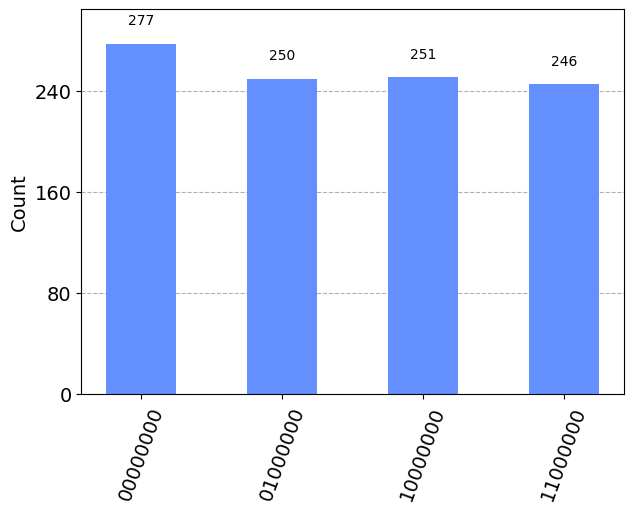

In [55]:
plot_histogram(counts)

{'11000000': 246, '00000000': 277, '01000000': 250, '10000000': 251}

In [69]:
fs = list()
for k in counts:
    fs.append(Fraction(int(k,2),2**(2*n)).denominator)

print(counts)
print(fs)
r = max(Counter(fs), key=Counter(fs).get)
print(r)

{'11000000': 246, '00000000': 277, '01000000': 250, '10000000': 251}
[4, 1, 4, 2]
4


In [71]:
if r%2==0:
    print(np.gcd(int(a**(r/2) - 1),N))
    print(np.gcd(int(a**(r/2) + 1),N))

3
5


In [21]:
def factorize(a,N,counts):
    fs = list()
    for k in counts:
        if counts[k] > 10:
            fs.append(Fraction(int(k,2),2**(2*n)).denominator)
    r = max(Counter(fs), key=Counter(fs).get)
    print('period of ',a,' mod ',N, ' is ' ,r)
    if r%2==0:
        print('1st factor: ',np.gcd(int(a**(r/2) - 1),N))
        print('2nd factor: ',np.gcd(int(a**(r/2) + 1),N))

In [75]:
factorize(a,N,counts)

period of  2  mod  15  is  4
1st factor:  3
2nd factor:  5


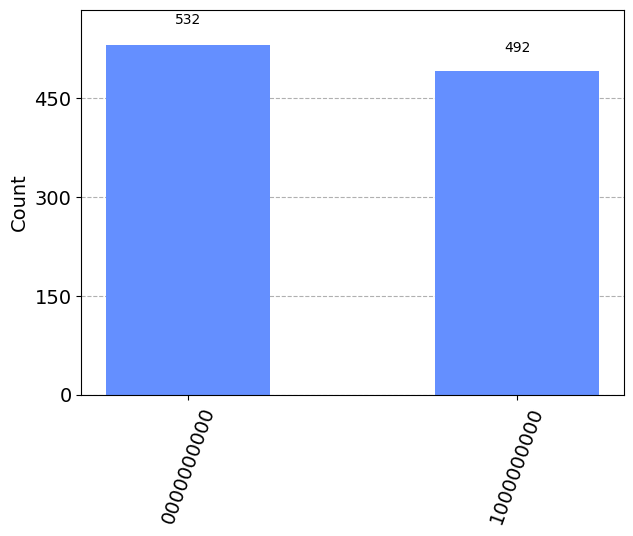

NameError: name 'factorize' is not defined

In [10]:
N = 21
n = int(np.ceil(np.log2(N)))
a = 8
final_circuit21 = shor(n,a,N)
counts21 = simulator.run(final_circuit21).result().get_counts()
display(plot_histogram(counts21))
factorize(a,N,counts21)

It Took 12 minutes to run this circuit

In [12]:
factorize(a,N,counts21)

period of  8  mod  21  is  2
1st factor:  7
2nd factor:  3


In [14]:
np.gcd(8,35)

1

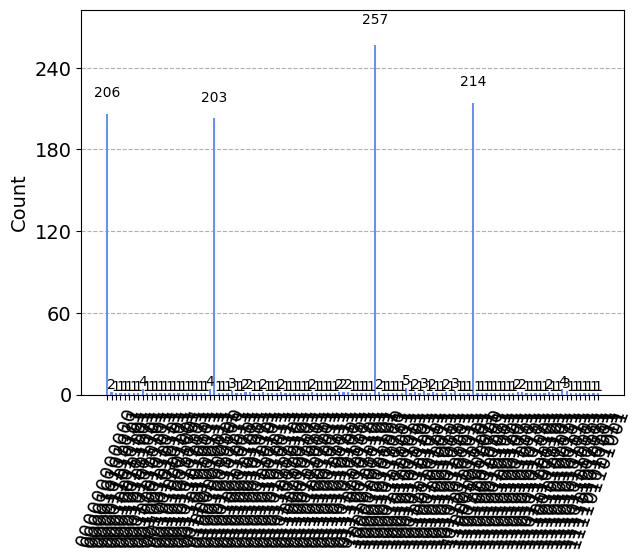

period of  8  mod  35  is  4096


OverflowError: (34, 'Result too large')

In [14]:
N = 35
n = int(np.ceil(np.log2(N)))
a = 8
final_circuit35 = shor(n,a,N)
counts35 = simulator.run(final_circuit35).result().get_counts()
display(plot_histogram(counts35))
factorize(a,N,counts35)

It took 190 minutes to do this simulation

In [20]:
fs = []
for count in counts35:
    c = counts35[count]
    if c > 10:
        fs.append(count)
fs

['100000000000', '000000000000', '110000000000', '010000000000']

In [22]:
factorize(a,N,counts35)

period of  8  mod  35  is  4
1st factor:  7
2nd factor:  5


In [23]:
fcounts35 = dict()
for count in counts35:
    c = counts35[count]
    if c > 10:
        fcounts35[count] = c

print(fcounts35)

{'100000000000': 257, '000000000000': 206, '110000000000': 214, '010000000000': 203}


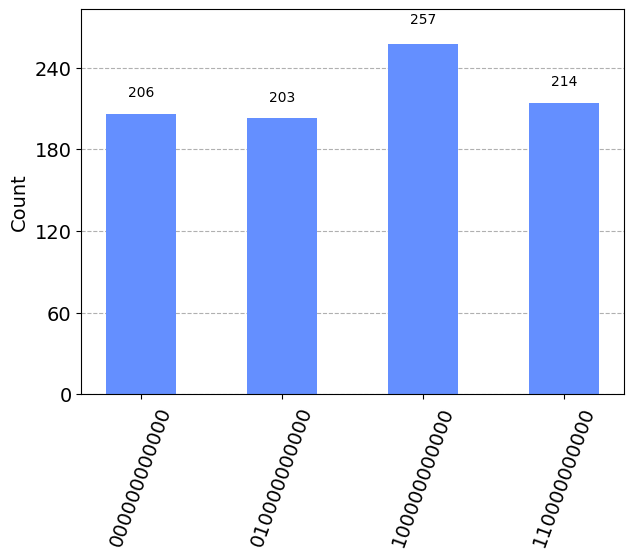

In [24]:
plot_histogram(fcounts35)